In [1]:
import os

import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from src.data.tf_data_hdf5 import get_tf_data, RandomStandardization 
from src.data.utils import get_lung_volume, get_split


os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
clinical_df = pd.read_csv("/home/valentin/python_wkspce/plc_segmentation/data/clinical_info_with_lung_info.csv").set_index("patient_id")

In [3]:
file = h5py.File(
    "/home/valentin/python_wkspce/plc_segmentation/data/processed/hdf5_2d/data_selected_slices.hdf5",
    "r")

In [4]:
patient_list = list(file.keys())
patient_list.remove("PatientLC_63")  # Just one lung
patient_list.remove("PatientLC_72")  # the same as 70

In [5]:
ids_train, ids_val, ids_test = get_split(0)

In [6]:
np.sum(clinical_df.loc[ids_train, "plc_status"].values)

37

In [7]:
len(ids_train)

50

In [8]:
np.sum(clinical_df.loc[ids_train, "plc_status"].values)

37

In [9]:
preprocessor = RandomStandardization(p=0.0)


In [10]:
ds_train = get_tf_data(
    file,
    clinical_df,
    patient_list=ids_train,
    shuffle=True,
    oversample=False,
    center_on="GTVl",
    random_angle=None,
    random_position=True,
).map(lambda im, mask, pstatus, p_id:
      (preprocessor(im), mask, pstatus, p_id)).batch(16)


In [11]:
images, masks, plc_status, patient_ids = next(ds_train.as_numpy_iterator())

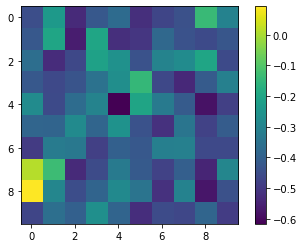

In [14]:
plt.imshow(images[0,100:110,100:110,0])
plt.colorbar()

In [12]:
masks.shape

(16, 256, 256, 4)

In [21]:
b = 5

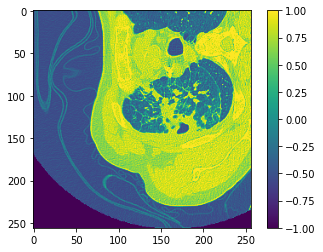

In [22]:
plt.imshow(images[b, :, :, 0])
plt.colorbar()

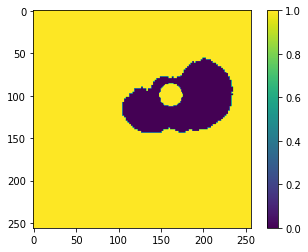

In [23]:
plt.imshow(masks[b, :, :, 3])
plt.colorbar()

In [ ]:
clinical_df.loc[patient_ids[b].decode("utf-8"), "plc_status"]

In [ ]:
plc_status[b], patient_ids[b]

In [ ]:
n_plc_neg = 0
n_plc_pos = 0
for images, segs, patient_id in ds_train.take(20).as_numpy_iterator():
    bs = images.shape[0]
    patient_id = [p.decode("utf-8") for p in patient_id]
    n_plc_pos += np.sum(clinical_df.loc[patient_id, "plc_status"].values == 1)
    n_plc_neg += np.sum(clinical_df.loc[patient_id, "plc_status"].values == 0)


In [ ]:
n_plc_pos

In [ ]:
n_plc_neg

In [ ]:
plt.imshow(images[3,:,:,:])

In [ ]:
image, mask = get_lung_volume("PatientLC_1", file)

In [ ]:
plt.imshow(image[:, :, -1, 0])

In [ ]:
ds = get_tf_data(
    file,
    clinical_df=clinical_df,
    # return_patient_name=True,
    patient_list=patient_list,
    return_complete_gtvl=True,
    random_slice=True,
    center_on="nothing",
    oversample=True,
).shuffle(buffer_size=10).repeat().take(1000).as_numpy_iterator()

In [ ]:
n_background = 0
n_gtvl = 0
for image, seg in ds:
    gtvl = seg[:, :, 1]
    n_gtvl += np.sum(gtvl[seg[:,:,3]!=0])
    n_background += np.sum((1-gtvl)[seg[:,:,3]!=0])
ratio_gtvl = n_gtvl / (n_background +  n_gtvl)
ratio_background = n_background / (n_background + n_gtvl)

In [ ]:
print(
    f"The class weights of gtvl and backgroun are {1/ratio_background/2}, {1/ratio_gtvl/2},  respectively "
)
print(
    f"The alpha for gtvl and background are {1-ratio_gtvl}, {1-ratio_background}, respectively "
)

In [ ]:
ratio_gtvl

In [ ]:
ds = get_tf_data(
    file,
    clinical_df=clinical_df,
    patient_list=["Case_1", "PatientLC_1", "PatientLC_2"],
    return_patient_name=True,
    return_complete_gtvl=True,
    random_slice=False,
    center_on="GTV L",
).shuffle(buffer_size=10).as_numpy_iterator()


In [ ]:
clinical_df.loc["PatientLC_2",:]

In [ ]:
image, mask, patient_id = next(ds)
patient_id

In [ ]:
plt.imshow(mask[:,:,1])

In [ ]:
image, mask = _parse_image(
    "PatientLC_2",
    clinical_df=clinical_df,
    file=file,
    random_slice=False,
    random_shift=False,
    center_on="GTV L",
    output_shape_image=(256, 256),
    return_complete_gtvl=True,
)

In [ ]:
plt.imshow(mask[:, :, 4])
